# Fit_models 
This funtionc will take a preprocessed dataframe, split and fit it into 8 models and return the accuracy of the prediction for each model.

In [1]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
import xgboost as xgb


def fit_models(df):
    
    df = df.dropna()
    train_size = int(len(df) * 0.9)
    train = df.iloc[:train_size, :]
    test = df.iloc[train_size:, :]

    target_name = df.columns[-1]
    train_X = train.drop(target_name, axis = 1)
    train_y = train[target_name]

    test_X = test.drop(target_name, axis = 1)
    test_y = test[target_name]
    
    models = []
    
    #Decision Tree
    models.append(('DT', DecisionTreeClassifier(max_depth=5)))
    
    # Random Forest
    models.append(('RF', RandomForestClassifier(max_depth=5)))
    
    # Gradient Boosting
    models.append(('GB', GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=5)))
    
    # XGBoost
    models.append(('XGB', xgb.XGBClassifier(use_label_encoder=False, eval_metric='error')))
    models.append(('SVC', SVC()))
    models.append(('KNN', KNeighborsClassifier()))
    
    # Logistic Regression
    models.append(('LR', LogisticRegression()))
    
    # Naive Bayes
    models.append(('NB', GaussianNB()))

    accuracies = dict()

    for name, model in models:

        model.fit(train_X, train_y)
        hyp = model.predict(test_X)
        accuracies[name] = accuracy_score(test_y, hyp) * 100.0
        
    return accuracies

# Fetch 6 companies data

This section fetches 6 different companies, APPLE, GOOGLE, AMD, TELSA, JP Morgan, and United Airline. After data is downloaded, they will be passed into the preprocess script (to generate indicators and target). Then, the preprocessed data will be passed into the fit_model function. 

In [2]:
import stock_helper
import pandas as pd
from datetime import datetime
import numpy as np

def date_to_day(df):
    # Convert date to the n-th day from 1970-01-01
    df['date'] = df['date'] \
        .apply(lambda date64: (date64 - np.datetime64('1970-01-01T00:00:00')) / np.timedelta64(1, 'D'))

stocks = ['AAPL', 'GOOG', 'AMD', 'TSLA', 'JPM', 'UAL']
stocks_dataset = [None] * len(stocks)

for i in range(len(stocks)):
    dataset = stock_helper.fetch_stock_data(stocks[i])
    stocks_dataset[i] = stock_helper.generate_indicators(dataset, 
                                     timeperiod=5, 
                                     generate_target=True, 
                                     reset_index=True)
    
    date_to_day(stocks_dataset[i])

In [3]:
dataset_accuracy = dict()
for i, df in enumerate(stocks_dataset):
    dataset_accuracy[stocks[i]] = fit_models(df)


# Visualize accuracies

This section visualize the accuracies of the 8 models for the 6 companies. The x-axis is algorithms and y-axis is accuracy in percentage. 

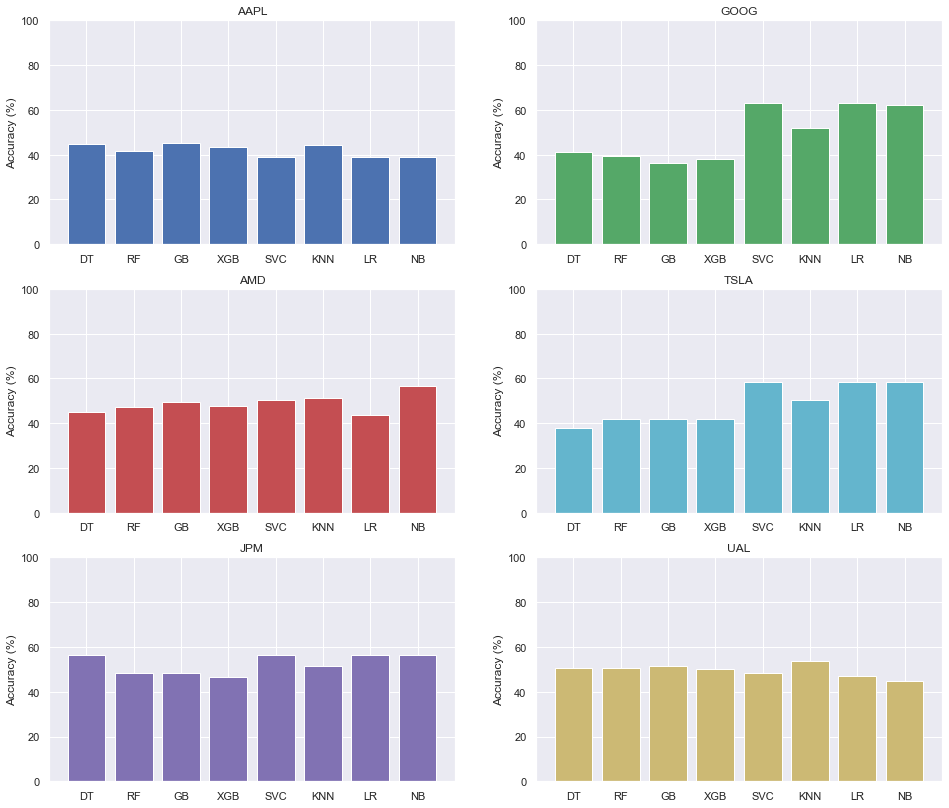

In [4]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16,14))

colors = ['b', 'g', 'r', 'c', 'm', 'y']
i = 0
for stock_name in dataset_accuracy:    
    data = dataset_accuracy[stock_name]
    ax_row = int(i/2)
    ax_colm = i % 2
    ax = axes[ax_row, ax_colm]
    ax.set_ylabel('Accuracy (%)')
    ax.set_ylim(0, 100)
    ax.set_title(stock_name)
    ax.bar(data.keys(), data.values(), color=colors[i])
    i+= 1

# Find out the best model

This cell shows each company has different preference on models, we will find out the best model for each stock.

In [5]:
for stock_name in dataset_accuracy:
    acc = dataset_accuracy[stock_name]
    highest = sorted(acc, key=acc.get, reverse=True)[:1]
    print("The best model for {stockname} is {model}, accuracy is {acc:.2f}%".format(stockname=stock_name,
                                                                                    model=highest[0],
                                                                                    acc=acc[highest[0]]))

The best model for AAPL is GB, accuracy is 45.08%
The best model for GOOG is SVC, accuracy is 63.16%
The best model for AMD is NB, accuracy is 56.43%
The best model for TSLA is SVC, accuracy is 58.30%
The best model for JPM is DT, accuracy is 56.23%
The best model for UAL is KNN, accuracy is 53.93%


# Tensorflow LSTM

Besides ML algorithms, we'd like to see how neural network performs in the stock market. As the cells presenting below, we applied google's stock but it does not give us a better performance. 

In [6]:
# Let's take one of the preprocessed dataset
# In this example, I'm going to use Google's stock

google = stocks_dataset[1].dropna()

In [7]:
from sklearn import preprocessing

history_points = 25

def get_features(dataset):
    data = dataset.copy()
    
    target_name = data.columns[-1]
    data = data.drop(target_name, axis=1)
    data = data.to_numpy()

    data_normaliser = preprocessing.MinMaxScaler()
    data_normalised = data_normaliser.fit_transform(data)
    
    # get the history_points * 5 features (open, clos, volum, etc) array * (rows - history_points) 
    features = np.array([data_normalised[i  : i + history_points].copy() for i in range(len(data_normalised) - history_points)])
    return features

In [8]:
target_name = google.columns[-1]

In [9]:
X = get_features(google)
result = google[target_name].iloc[history_points:]
Y = np.expand_dims(result, axis=-1)

In [10]:
split_point = int(len(google) * 0.9)

train_X = X[:split_point]
train_y = Y[:split_point]

test_X = X[split_point:]
test_y = Y[split_point:]

In [11]:
import tensorflow as tf
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
from keras import optimizers
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, InputLayer,Embedding,SpatialDropout1D

# model definition
lstm_input = Input(shape=(history_points, 18), name='lstm_input')
x = LSTM(history_points, name='lstm_0')(lstm_input)
x = Dropout(0.2, name='lstm_dropout_0')(x)
x = Dense(32, name='dense_0')(x)
x = Activation('sigmoid', name='sigmoid_0')(x)
x = Dense(1, name='dense_1')(x)
# output = tf.nn.softmax(x)
model = Model(inputs=lstm_input, outputs=x)

adam = optimizers.Adam(lr=0.001)

model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

# Result of LSTM
We can see that LSTM has a fair accuracy. The best ML model for Google is SVC with 63% accuracy. The LSTM got about 58% during the epoch, but it acutally got 62% on evaluation. 
We've tuned some parameters and that's the best we can find out. We believe those ML models are accurate enough so the neural network will not be applied in our final script because it takes too much time to prepare data and tune.

In [12]:
model.fit(x=train_X,
          y=train_y,
          batch_size=16,
          epochs=20)

Epoch 1/20
236/236 [==============================] - 3s 6ms/step - loss: 0.6900 - accuracy: 0.5515
Epoch 2/20
236/236 [==============================] - 1s 6ms/step - loss: 0.6879 - accuracy: 0.5540
Epoch 3/20
236/236 [==============================] - 1s 6ms/step - loss: 0.6853 - accuracy: 0.5667
Epoch 4/20
236/236 [==============================] - 1s 6ms/step - loss: 0.6871 - accuracy: 0.5558
Epoch 5/20
236/236 [==============================] - 1s 6ms/step - loss: 0.6896 - accuracy: 0.5530
Epoch 6/20
236/236 [==============================] - 1s 6ms/step - loss: 0.6854 - accuracy: 0.5633
Epoch 7/20
236/236 [==============================] - 1s 6ms/step - loss: 0.6874 - accuracy: 0.5755
Epoch 8/20
236/236 [==============================] - 1s 6ms/step - loss: 0.6920 - accuracy: 0.5515
Epoch 9/20
236/236 [==============================] - 1s 6ms/step - loss: 0.6832 - accuracy: 0.5544
Epoch 10/20
236/236 [==============================] - 1s 6ms/step - loss: 0.6813 - accuracy: 0.5758

In [13]:
evaluation = model.evaluate(test_X, test_y)
print(evaluation)

13/13 [==============================] - 0s 2ms/step - loss: 0.6604 - accuracy: 0.6234
[0.6603712439537048, 0.6234096884727478]


In [14]:
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import binarize
import math

y_pred = model.predict(test_X)

y_bin = [y > 0.5 for y in y_pred]

confusion_matrix(test_y, y_bin)

array([[ 25, 119],
       [ 29, 220]])